# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\Users\Алексей\Downloads\real_estate_data.csv", sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

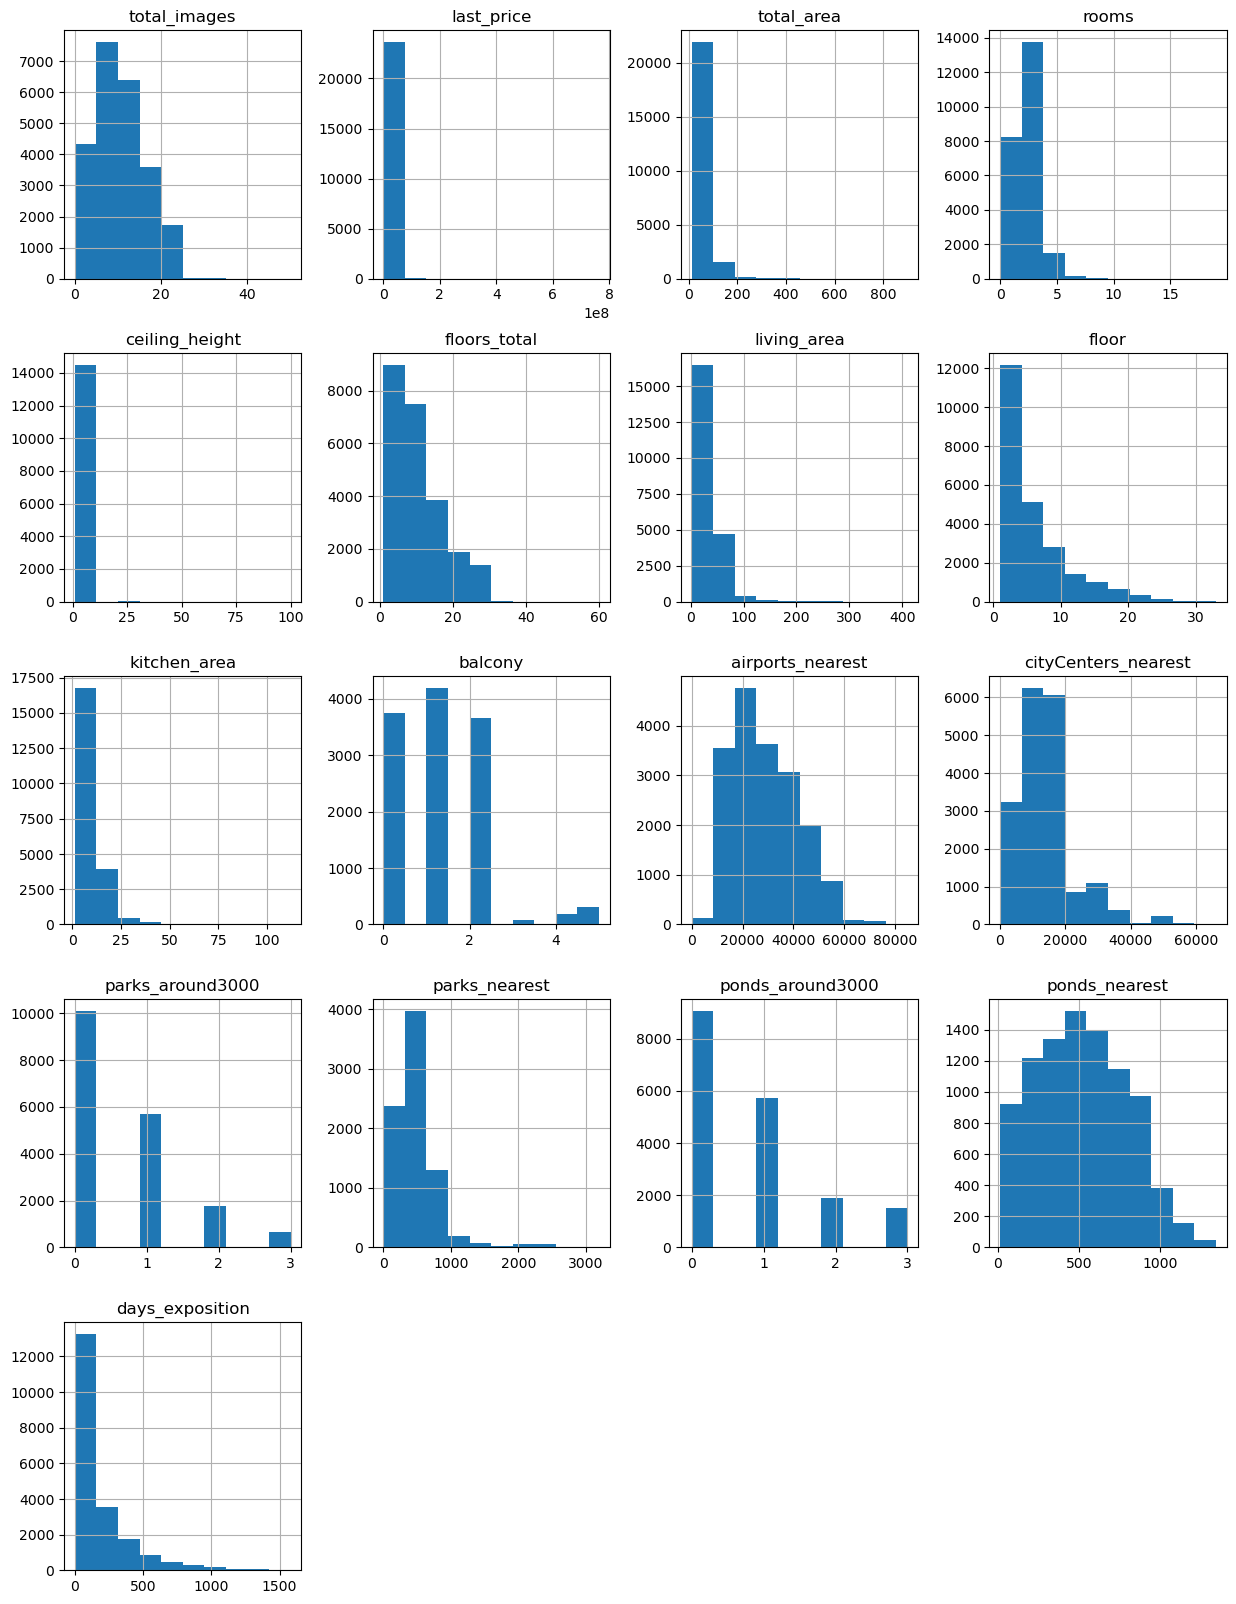

In [5]:
# постоим гистограммы распределения для всех числовых столбцов
df.hist(figsize=(15, 20))
plt.show()

### Выполните предобработку данных

In [6]:
# приведем названия полей к змеинному регистру
df = df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

#### Проверим данные на наличие пропусков и обработаем их

In [7]:
# посчитаем количество пропусков в каждом столбце
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Сделаем предположения о природе пропусков для каждого поля:
- в поле **ceiling_height** пропуски, вероятно, связаны с незнанием высоты потолков пользователем, заполнявшим данные
- в поле **floors_total** предположим, что число этажей не проставлено для одноэтажных домов
- в поле **living_area** причина, скорее всего, в незнании пользователем точной площади
- в поле **is_apartment**, вероятно, пропущены значения False
- в поле **kitchen_area** пропуски могут быть той же природы, что и в living_area. Однако, есть вероятность что значения пропущены для помещений без кухни
- в поле **balcony** предположим, что пропущены значения 0 для помещений без балкона
- объяснить пропуски в поле **locality_name** трудно. Возможно, имело место невнимательность при заполнении
- поля **airports_nearest, city_centers_nearest, parks_around3000, ponds_around3000** получены автоматически на основе картографических данных. Учитывая большое количество пропущенных значений, можно предположить, что пропуски связаны с техническими проблемами
- в полях **ponds_nearest** и **parks_nearest** значения пропущены, вероятно, во всех строках где пропущены значения **parks_around3000** и **ponds_around3000**, а также в строках где данные значения равны нулю.
- в поле **days_exposition** содержится количество дней от публикации до снятия объявления о продаже. Можно было бы предположить, что пропущенные значения означают, что объявление не снято. Однако отстутствие пропусков в поле last_price(цена на момент снятия с публикации) опровергает эту гипотезу. Предположим, что значения пропущены при продаже объекта в день публикации объявления

In [8]:
# заполним пропуски в поле ceiling_height медианным значением
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

In [9]:
# Проверим, находятся ли все объеты с пропусками в поле floors_total в одноэтажных домах
df[df['floors_total'].isna()]['floor'].value_counts()

floor
4     10
6      9
8      8
12     6
9      5
21     4
5      4
7      4
3      4
19     3
11     3
13     3
1      3
18     3
15     3
10     3
24     2
2      2
20     2
14     2
22     1
17     1
23     1
Name: count, dtype: int64

Гипотеза о том, что все объеты с пропусками в поле floors_total находятся в одноэтажных домах **не подтвердилась**. Значит - установить этажность дома не получится. Учитавая небольшое количество пропусков в данном поле, можно удалить соответствующие строки

In [10]:
df = df.dropna(subset=['floors_total'])

В поле living_area заполним пропуски медианным значением

In [11]:
# заполним пропуски в поле living_area медианным значением
df['living_area'] = df['living_area'].fillna(df['living_area'].median())

В поле is_apartment предположим, что пропущены значения False

In [12]:
# заполним пропуски в поле is_apartment значением False
df['is_apartment'] = df['is_apartment'].fillna(False)

C:\Users\Алексей\AppData\Local\Temp\ipykernel_15496\1744463677.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_apartment'] = df['is_apartment'].fillna(False)


Для заполнения пропусков в поле kitchen_area найдем медианное соотношение площади кухни к общей площади

In [13]:
kitchen_area_ratio = (df['kitchen_area'] / df['total_area']).median()
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area'] * kitchen_area_ratio)

В поле balcony пропущенные значения примем за отсутствие балконов

In [14]:
# заполним пропуски в поле balcony значением 0
df['balcony'] = df['balcony'].fillna(0)

Пропуски в поле locality_name для целей исследования не несут большой важности. Проигнорируем пропущенные значения

In [28]:
# проверим, что пропуски в полях с автоматическим заполнением приходятся на одни и те же строки
df[(df['airports_nearest'].isna()) & 
   (df['city_centers_nearest'].isna()) & 
   (df['parks_around3000'].isna()) & 
   (df['ponds_around3000'].isna())].isna().sum()

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
city_centers_nearest    0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
price_1m2               0
weekday_exposition      0
month_exposition        0
year_exposition         0
floor_type              0
dtype: int64

In [16]:
df[(df['ponds_around3000'] == 0) & (df['ponds_nearest'].isna())]['ponds_around3000'].count()

9044

In [17]:
df[(df['parks_around3000'] == 0) & (df['parks_nearest'].isna())]['parks_around3000'].count()

10060

In [18]:
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['days_exposition'] = df['days_exposition'].fillna(0)

Во всех полях, полученых атоматически из геосервисов, пропущены значения в одних и тех же строках, что подтверждает гипотезу о технических проблемах при получении данных. Для решения этой проблемы необходимо запросить выгрузку данных повторно. В полях **ponds_nearest** и **parks_nearest** также пропущены значения в строках, где значения **ponds_around3000** и **parks_around3000** равны 0.

В полях **parks_around3000** и **ponds_around3000** заполним пропуски значением 0 (т.е. предположим что таких обхектов в пределах 3 км нет).
В полях  **airports_nearest, city_centers_nearest, ponds_nearest** и **parks_nearest** оставим пропуски без изменений.

**Таким образом, можно сделать выводы по обработке пропусков в данных:**
- в полях ceiling_height и living_area пропуски заполнены медианными значениями;
- из за небольшого количества пропусков в полеfloors_total, строки с данными пропусками были удалены;
- в поле is_apartment прпуски заполнены значениями False;
- пропуски в поле kitchen_area заполнены по медианной доле площади кухни от общей площади;
- в поле balcony пропуски заполнены значение 0;
- пропуски в поле locality_name были проигнорированы, так как не влияют на выполнение исследования;
- в полях airports_nearest, cityCenters_nearest, ponds_nearest и parks_nearest пропуски также были проигнорированы;
- в полях parks_around3000, ponds_around3000, а также days_exposition пропуски заполнены значением 0.

In [19]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              48
airports_nearest         5532
city_centers_nearest     5509
parks_around3000            0
parks_nearest           15568
ponds_around3000            0
ponds_nearest           14552
days_exposition             0
dtype: int64

#### Установим корректные типы данных для всех полей

In [20]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['floors_total'] = df['floors_total'].astype('int')
df['is_apartment'] = df['is_apartment'].astype('bool')
df['balcony'] = df['balcony'].astype('int')
df['parks_around3000'] = df['parks_around3000'].astype('int')
df['ponds_around3000'] = df['ponds_around3000'].astype('int')
df['days_exposition'] = df['days_exposition'].astype('int')
df.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int32
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest               float64
city_centers_nearest           float64
parks_around3000                 int32
parks_nearest                  float64
ponds_around3000                 int32
ponds_nearest                  float64
days_exposition                  int32
dtype: object

#### Проверим данные на наличие явных и неявных дубликатов

In [21]:
df.duplicated().sum()

0

Явных дубликов в данных нет. Проверим на неявные дубликаты поле **locality_name**

In [22]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Названия населенных пунктов написаны в разном стиле - где-то указан тип населенного пункта, где-то только название, что может вести к наличию дубликатов. Созданим функцию для очистки названий от дополнительных слов.

In [39]:
def locality_names_hander(name):
    remove_parts = ['поселок', 'городской', 'деревня', 'городского типа', 
                    'садовое товарищество', 'село', 'садоводческое некоммерческое товарищество',
                    'при железнодорожной', 'станции', 'коттеджный']
    if not isinstance(name, float):
        n = name.replace("ё", "е")
        for part in remove_parts:
            n = n.replace(part, '')
        n = n.strip()
        return n
    return name

In [47]:
# применим функцию locality_names_hander и выведем значения поля locality_name в алфавитном порядке
df['locality_name'] = df['locality_name'].apply(locality_names_hander)
sorted(df[~df['locality_name'].isna()]['locality_name'].unique())

['Агалатово',
 'Александровская',
 'Алексеевка',
 'Аннино',
 'Аро',
 'Барышево',
 'Батово',
 'Бегуницы',
 'Белогорка',
 'Белоостров',
 'Бокситогорск',
 'Большая Вруда',
 'Большая Ижора',
 'Большая Пустомержа',
 'Большие Колпаны',
 'Большое Рейзино',
 'Большой Сабск',
 'Бор',
 'Борисова Грива',
 'Бугры',
 'Будогощь',
 'Ваганово',
 'Важины',
 'Вартемяги',
 'Вахнова Кара',
 'Вещево',
 'Виллози',
 'Вознесенье',
 'Возрождение',
 'Войсковицы',
 'Войскорово',
 'Володарское',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Вырица',
 'Выскатка',
 'Высокоключевой',
 'Высоцк',
 'Гаврилово',
 'Гарболово',
 'Гатчина',
 'Гладкое',
 'Глажево',
 'Глебычево',
 'Глинка',
 'Гончарово',
 'Горбунки',
 'Гостилицы',
 'Громово',
 'Дзержинского',
 'Дружная Горка',
 'Дружноселье',
 'Дубровка',
 'Елизаветино',
 'Ефимовский',
 'Жил',
 'Жилгородок',
 'Житково',
 'Заводской',
 'Заклинье',
 'Заневка',
 'Запорожское',
 'Зеленогорск',
 'Зимитицы',
 'Ивангород',
 'Извара',
 'Ильичево',
 'Иссад',
 'Калитино',
 'Кало

После обработки дубликатов в поле locality_name не выявлено

### Добавьте в таблицу новые столбцы

Добавим в таблицу столбцы:
- **price_1m2:** цена 1 кв метра
- **weekday_exposition:** день недели публикации объявления
- **month_exposition:** месяц публикации объявления
- **year_exposition:** год публикации объявления
- **floor_type:** тип этажа квартиры (значения — «первый», «последний», «другой»)
- **city_centers_nearest_km:** расстояние до центра города в километрах

Для определения типа этажа квартиры создадим функцию *floor_type*

In [25]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

In [52]:
df['price_1m2'] = round(df['last_price'] / df['total_area'], 2)
df['weekday_exposition'] = df['first_day_exposition'].dt.dayofweek
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year
df['floor_type'] = df.apply(floor_type, axis=1)
df['city_centers_nearest_km'] = (df['city_centers_nearest'] / 1000).round()

### Проведите исследовательский анализ данных

Исследуем основные параметры объектов недвижимости. Посмотрим на распределения значений и возможные выбросы, построив гистограммы для каждого параметра

In [53]:
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1m2,weekday_exposition,month_exposition,year_exposition,floor_type,city_centers_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2,755.0,0,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0,NaN,81,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2,574.0,558,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,30.0,9,False,...,84.0,3,234.0,424,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1,48.0,121,100000.00,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.3,3,False,...,796.0,3,381.0,0,72490.85,1,3,2017,другой,4.0
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5,38.0,4,False,...,NaN,0,NaN,45,52542.37,0,1,2018,другой,NaN
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3,29.7,1,False,...,NaN,0,NaN,0,44091.71,6,2,2018,первый,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,30.0,12,False,...,173.0,3,196.0,602,149511.40,1,3,2017,другой,10.0


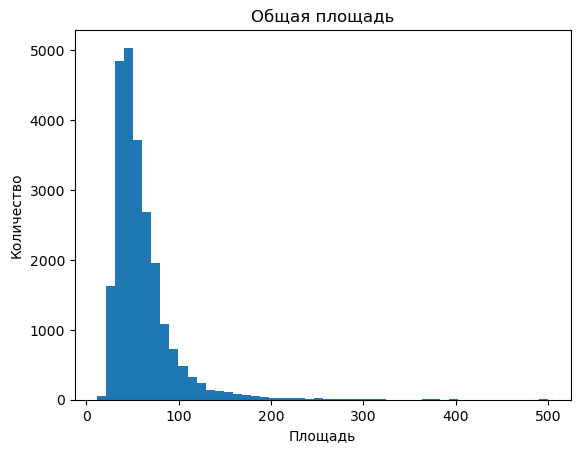

In [81]:
plt.hist(x=df['total_area'], bins=50)
plt.title('Общая площадь')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()

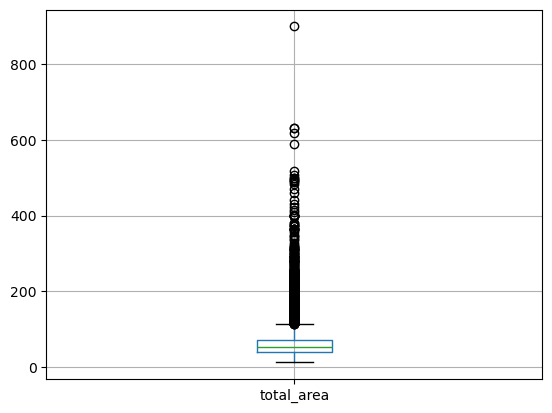

In [74]:
df.boxplot('total_area')
plt.show()

In [75]:
df['total_area'].describe()

count    23613.000000
mean        60.340678
std         35.648988
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

Подавляющая доля объектов имеет общую площадь в пределах от 30 до 100 кв метров. Однако, достаточно много значений находится в диапазоне до 500 кв метров. После встречаются лишь отдельные выбросы. Отфильтруем их

In [76]:
df = df[df['total_area'] <= 500]

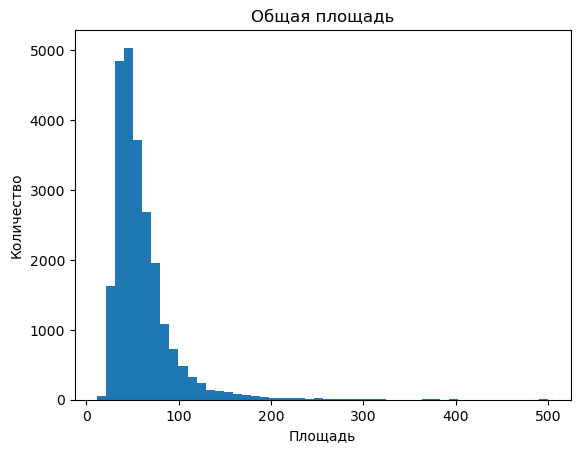

In [79]:
plt.hist(x=df['total_area'], bins=50)
plt.title('Общая площадь')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()

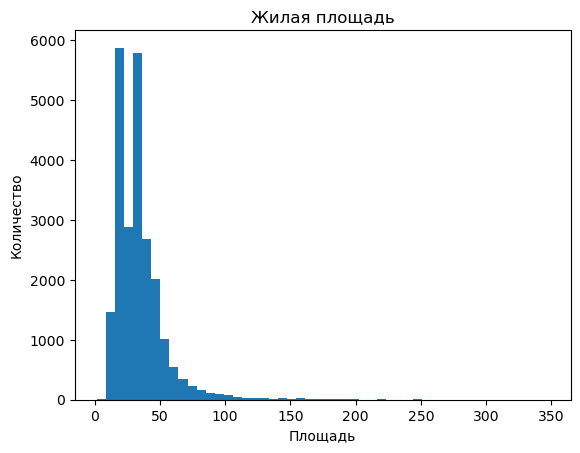

In [85]:
plt.hist(x=df['living_area'], bins=50)
plt.title('Жилая площадь')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()

count    23568.000000
mean        33.892089
std         19.916714
min          2.000000
25%         19.000000
50%         30.000000
75%         41.000000
max        250.000000
Name: living_area, dtype: float64

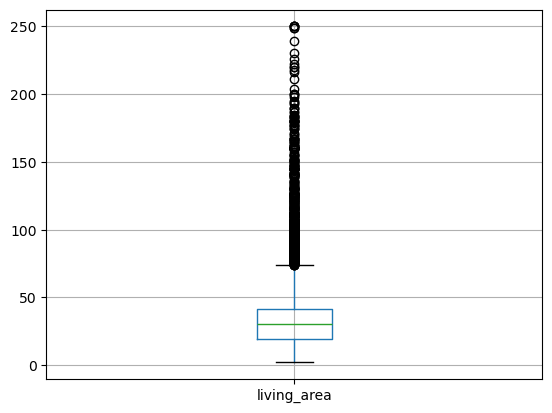

In [102]:
df.boxplot('living_area')
df['living_area'].describe()

Основная масса объектов имеет жилую площадь от 10 до 100 кв метров. Достаточно много значений находится в диапазоне до 250 кв метров. Оставим строки со значением living_area до 250 кв метров.

In [89]:
df = df[df['living_area'] <= 250]

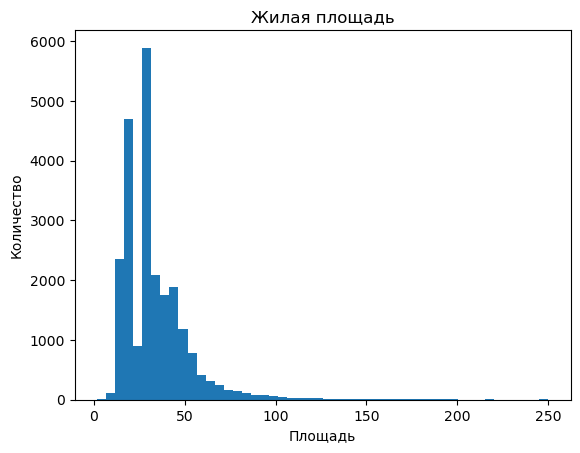

In [90]:
plt.hist(x=df['living_area'], bins=50)
plt.title('Жилая площадь')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()

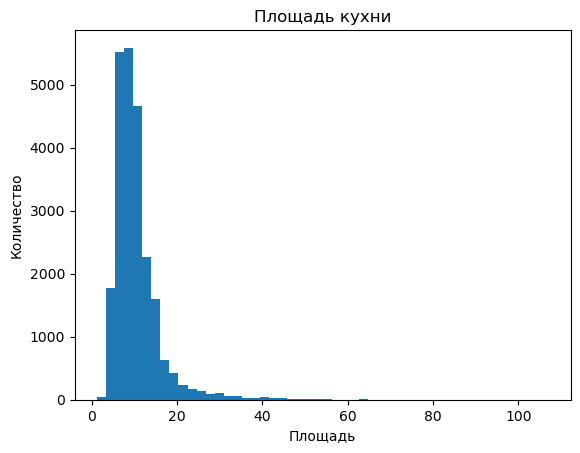

In [91]:
plt.hist(x=df['kitchen_area'], bins=50)
plt.title('Площадь кухни')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()

count    23568.000000
mean        10.382504
std          5.448985
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max         60.000000
Name: kitchen_area, dtype: float64

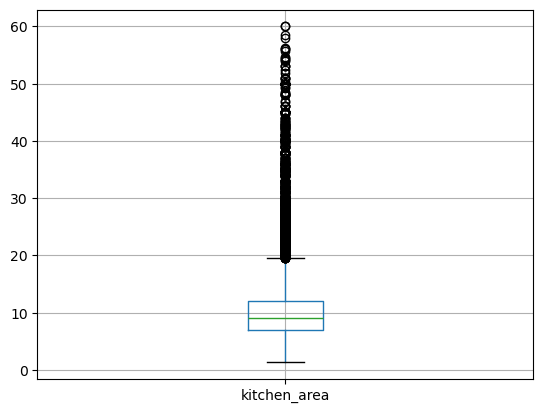

In [101]:
df.boxplot('kitchen_area')
df['kitchen_area'].describe()

Основная масса объектов имеет площадь кухни от 5 до 20 кв метров. Достаточно много значений находится в диапазоне до 60 кв метров. Отфильтруем строки со значением kitchen_area более 60

In [95]:
df = df[df['kitchen_area'] <= 60]

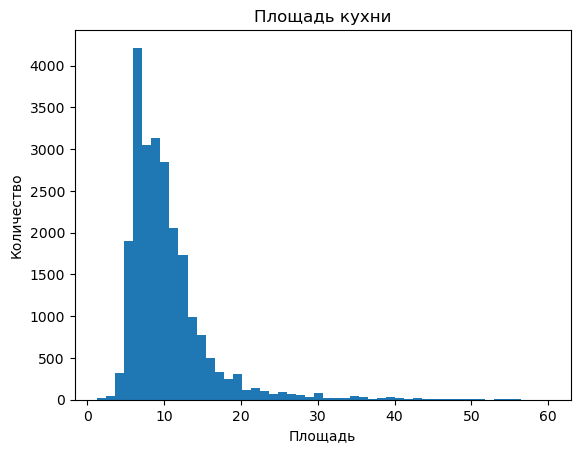

In [96]:
plt.hist(x=df['kitchen_area'], bins=50)
plt.title('Площадь кухни')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()

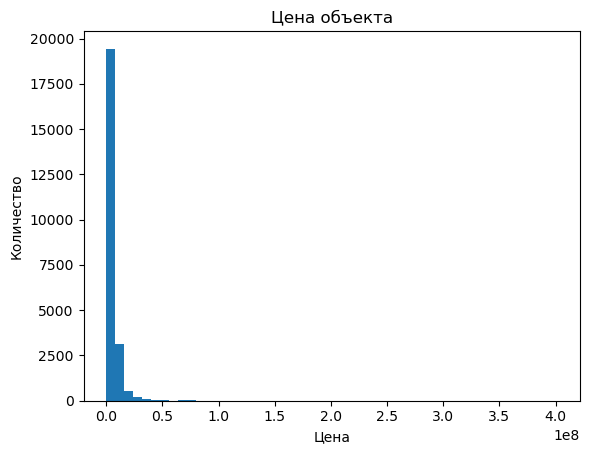

In [97]:
plt.hist(x=df['last_price'], bins=50)
plt.title('Цена объекта')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

count    2.356800e+04
mean     6.365215e+06
std      8.552054e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.622500e+06
75%      6.750000e+06
max      4.013000e+08
Name: last_price, dtype: float64

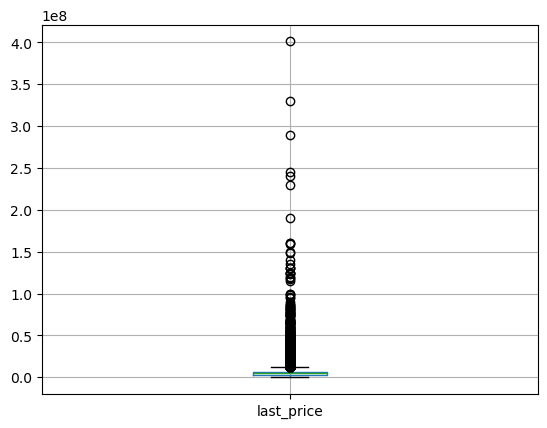

In [100]:
df.boxplot('last_price')
df['last_price'].describe()

Основная часть объектов имеет цену до 100 млн. Цены выше примем за выбросы и отфильтруем

In [103]:
df = df[df['last_price'] <= 100_000_000]

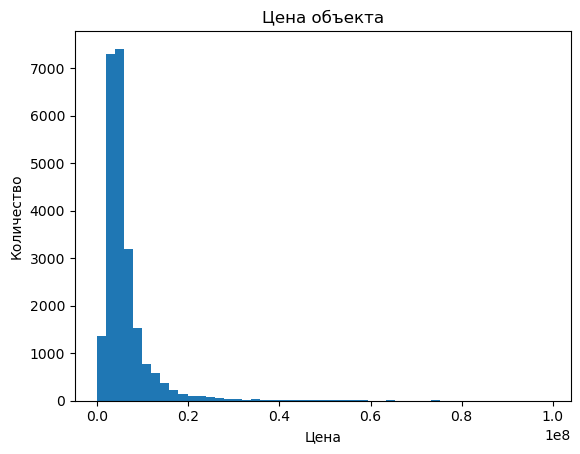

In [104]:
plt.hist(x=df['last_price'], bins=50)
plt.title('Цена объекта')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

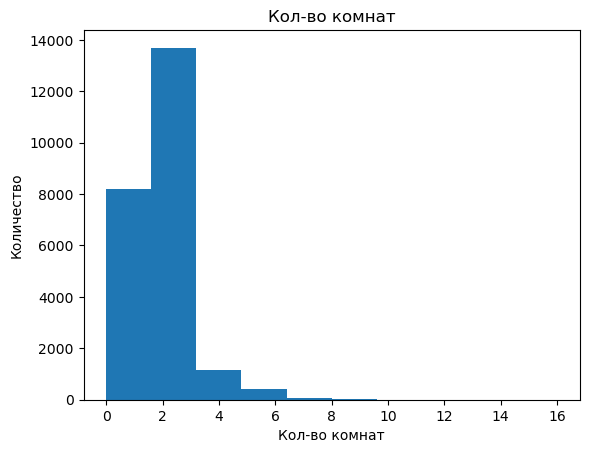

In [106]:
plt.hist(x=df['rooms'], bins=10)
plt.title('Кол-во комнат')
plt.xlabel('Кол-во комнат')
plt.ylabel('Количество')
plt.show()

count    23543.000000
mean         2.062014
std          1.055978
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64

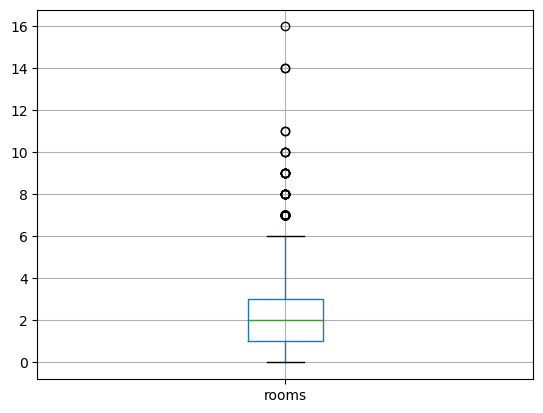

In [107]:
df.boxplot('rooms')
df['rooms'].describe()

Примем за выбросы объекты с количеством комнат выше 6

In [109]:
df = df[df['rooms'] <= 6]

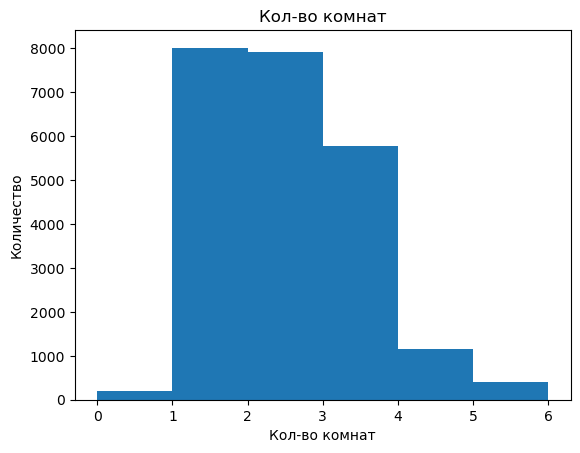

In [113]:
plt.hist(x=df['rooms'], bins=6)
plt.title('Кол-во комнат')
plt.xlabel('Кол-во комнат')
plt.ylabel('Количество')
plt.show()

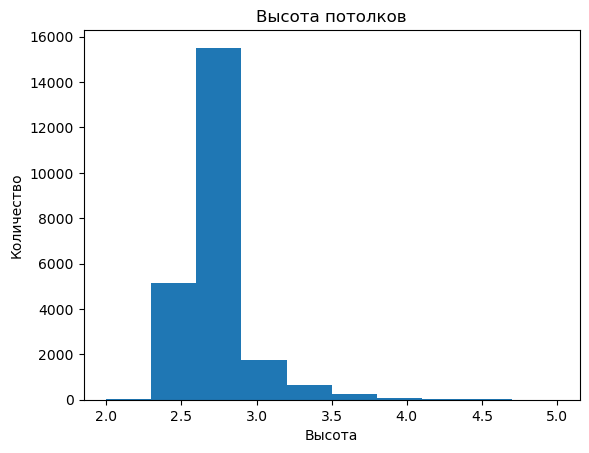

In [142]:
plt.hist(x=df['ceiling_height'], bins=10)
plt.title('Высота потолков')
plt.xlabel('Высота')
plt.ylabel('Количество')
plt.show()

count    23469.000000
mean         2.721425
std          0.991154
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

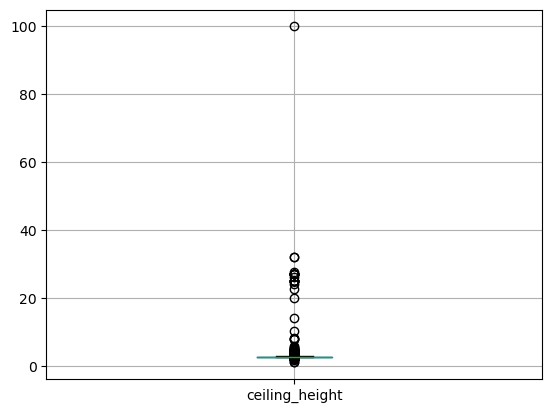

In [115]:
df.boxplot('ceiling_height')
df['ceiling_height'].describe()

В поле ceiling_height имеются значительные выбросы. Существование объектов с высотой пололка выше 5 метров кажется маловероятным. Можно предположить, что в значених от 20 метров была допущена ошибка с разрядностью числа. Разделим такие значения на 10. Значения от 5 до 20 отфильтруем. Также отфильтруем как маловероятные значение высоты пололка ниже 2 метров

In [122]:
def ceiling_height_limit(h):
    if h >= 20:
        return h / 10
    return h

In [129]:
df['ceiling_height'] = df['ceiling_height'].apply(ceiling_height_limit)
df = df[(df['ceiling_height'] >= 2) & (df['ceiling_height'] <= 5)]

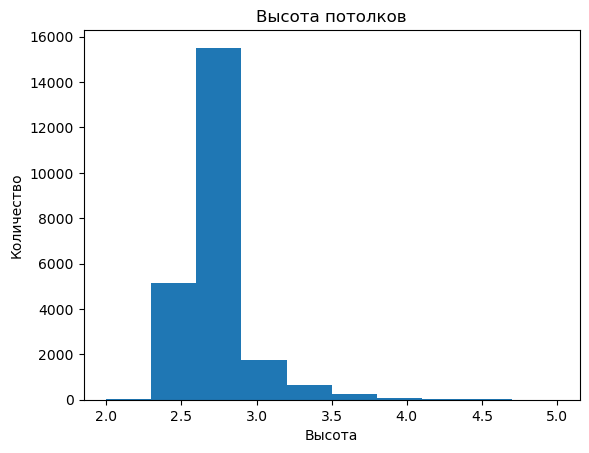

In [143]:
plt.hist(x=df['ceiling_height'], bins=10)
plt.title('Высота потолков')
plt.xlabel('Высота')
plt.ylabel('Количество')
plt.show()

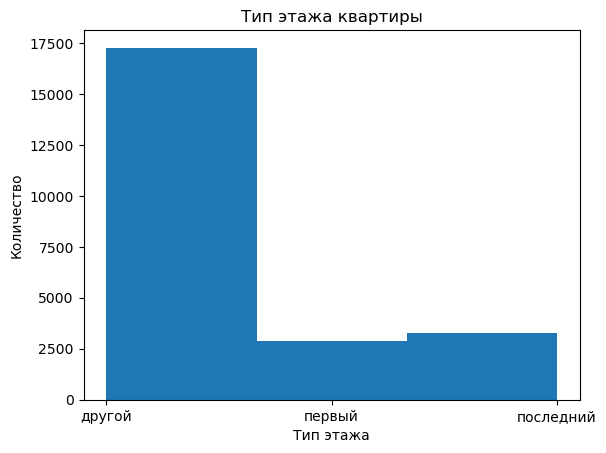

In [131]:
plt.hist(x=df['floor_type'], bins=3)
plt.title('Тип этажа квартиры')
plt.xlabel('Тип этажа')
plt.ylabel('Количество')
plt.show()

Менее трети объектов расположены на первом либо последнем этажах

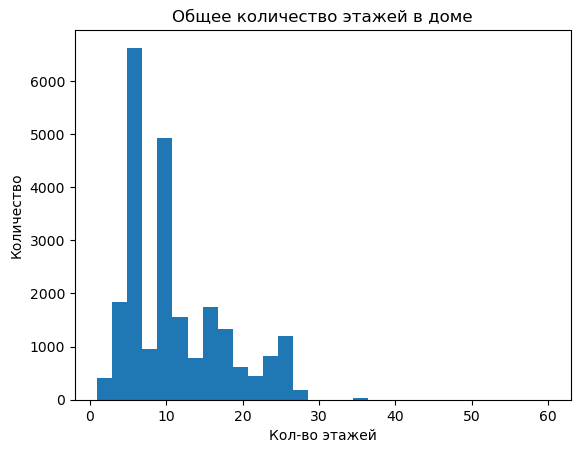

In [134]:
plt.hist(x=df['floors_total'], bins=30)
plt.title('Общее количество этажей в доме')
plt.xlabel('Кол-во этажей')
plt.ylabel('Количество')
plt.show()

count    23455.000000
mean        10.702238
std          6.602074
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

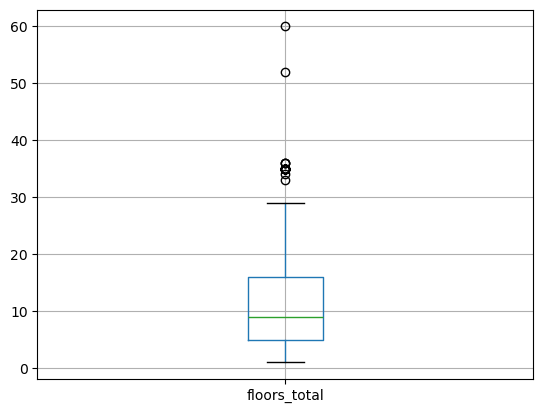

In [135]:
df.boxplot('floors_total')
df['floors_total'].describe()

Основная доля объектов расположена до 30 этажа. Значения выше отфильтруем

In [136]:
df = df[df['floors_total'] <= 30]

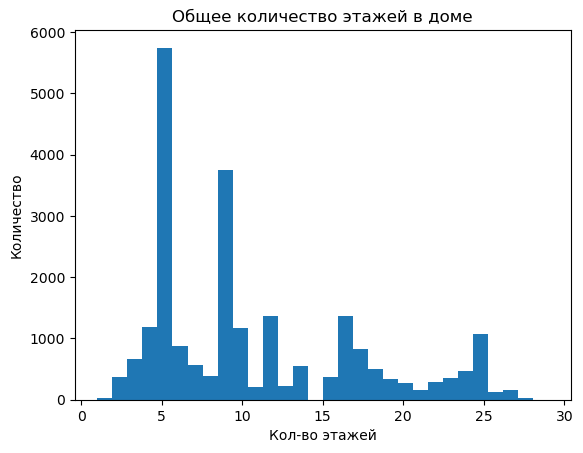

In [137]:
plt.hist(x=df['floors_total'], bins=30)
plt.title('Общее количество этажей в доме')
plt.xlabel('Кол-во этажей')
plt.ylabel('Количество')
plt.show()

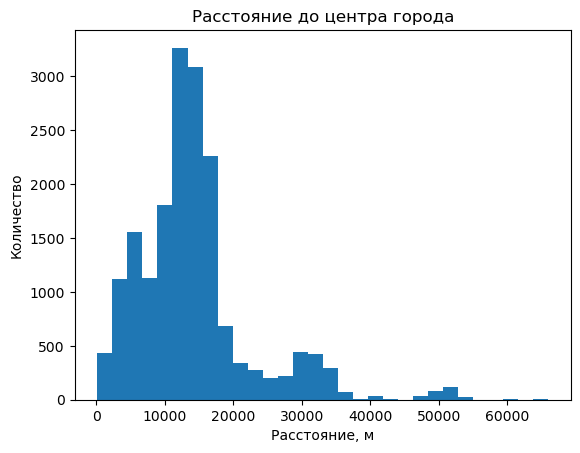

In [140]:
plt.hist(x=df['city_centers_nearest'], bins=30)
plt.title('Расстояние до центра города')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество')
plt.show()

count    17920.000000
mean     14238.849442
std       8602.191628
min        181.000000
25%       9350.000000
50%      13125.000000
75%      16293.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

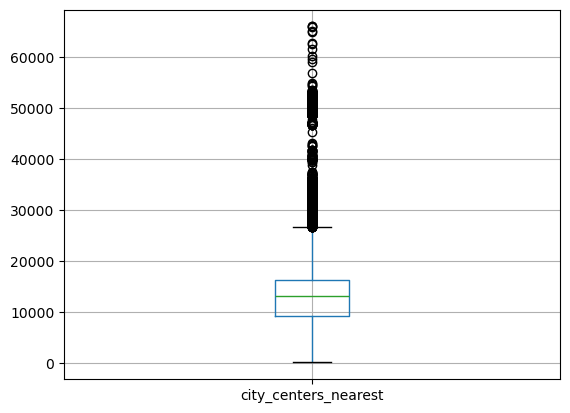

In [141]:
df.boxplot('city_centers_nearest')
df['city_centers_nearest'].describe()

Основная масса объектов расположено в пределах 20 км от центра города. Имеются необычные пики распределения при значениях около 30 км и около 50 км. Можно предположить, что здесь также допущена ошибка в разрядности чисел, однако такое допущение может значительно повлиять на результаты исследования. На данном этапе просто отфильтруем строки со значением city_centers_nearest более 60 000

In [144]:
df = df[df['city_centers_nearest'] <= 60_000]

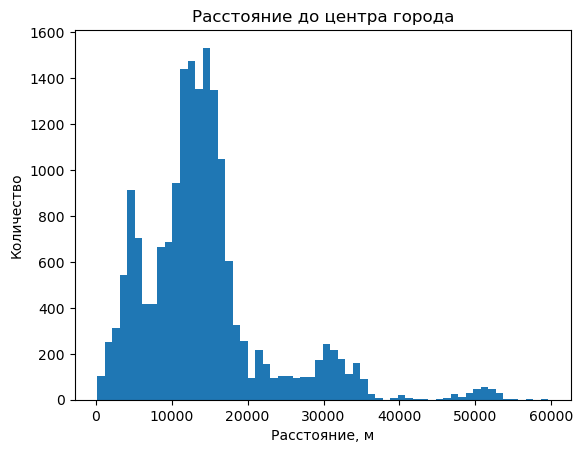

In [146]:
plt.hist(x=df['city_centers_nearest'], bins=60)
plt.title('Расстояние до центра города')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество')
plt.show()

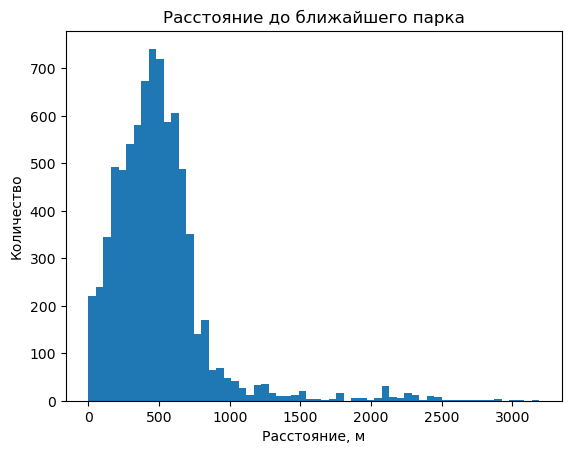

In [147]:
plt.hist(x=df['parks_nearest'], bins=60)
plt.title('Расстояние до ближайшего парка')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество')
plt.show()

count    7924.000000
mean      491.479682
std       341.977034
min         1.000000
25%       288.000000
50%       455.500000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

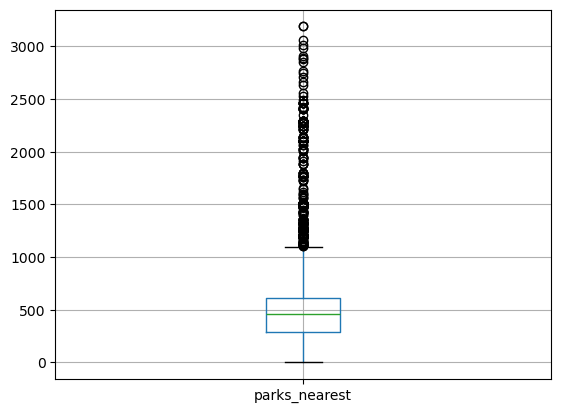

In [148]:
df.boxplot('parks_nearest')
df['parks_nearest'].describe()

Отфильтруем значения в поле parks_nearest выше 3000

In [149]:
df = df[df['parks_nearest'] <= 3_000]

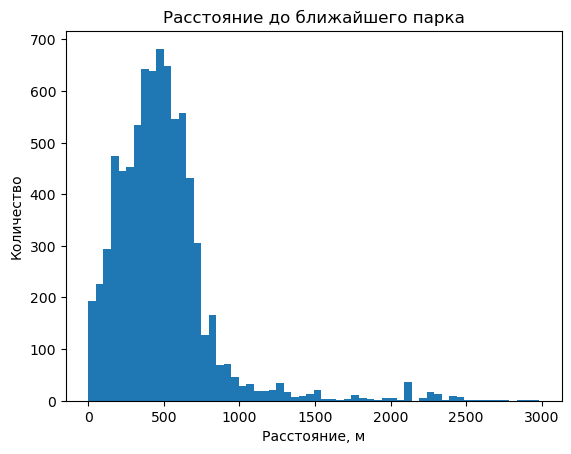

In [150]:
plt.hist(x=df['parks_nearest'], bins=60)
plt.title('Расстояние до ближайшего парка')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество')
plt.show()

#### Изучим, как быстро продавались квартиры, проанализировав поле days_exposition

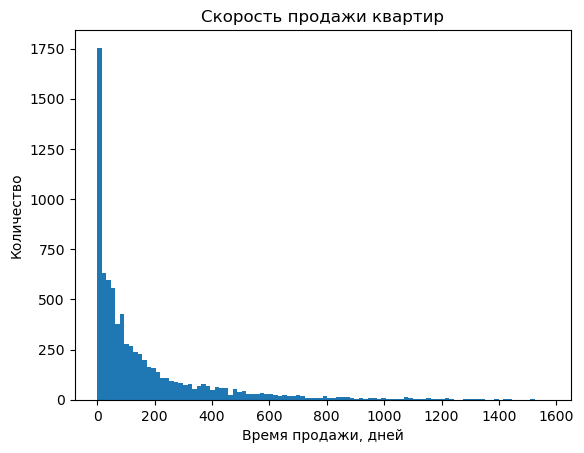

In [157]:
plt.hist(x=df['days_exposition'], bins=100)
plt.title('Скорость продажи квартир')
plt.xlabel('Время продажи, дней')
plt.ylabel('Количество')
plt.show()

count    7920.000000
mean      166.056061
std       226.085511
min         0.000000
25%        21.000000
50%        80.000000
75%       211.000000
max      1572.000000
Name: days_exposition, dtype: float64

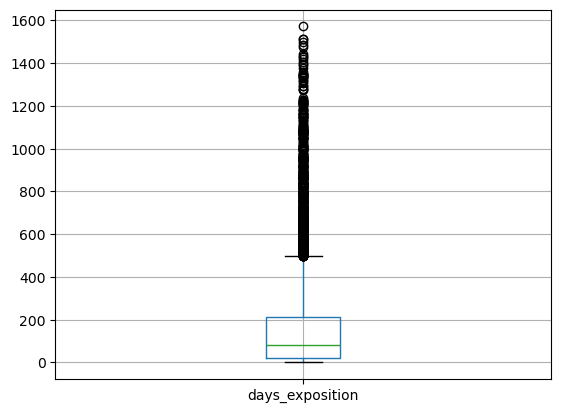

In [158]:
df.boxplot('days_exposition')
df['days_exposition'].describe()

Найдем границы условно быстрых и условно медленных продаж. Условно быстрыми назовем значения до 20 процентиля, условно долгими - после 80 процентиля.

In [180]:
# разобьем значения days_exposition на 5 равных частей по количеству значений
sorted(pd.qcut(df['days_exposition'], 5).unique())

[Interval(-0.001, 12.0, closed='right'),
 Interval(12.0, 55.0, closed='right'),
 Interval(55.0, 117.0, closed='right'),
 Interval(117.0, 269.0, closed='right'),
 Interval(269.0, 1572.0, closed='right')]

Продажа квартир, как правило, занимает до 500 дней. Среднее значение времени продажи составило 166 дней, медианное значение - 80 дней. Условно быстрыми продажами назовем продажи, занявшие не более 21 дня, условно долгими - продажи, занявшие более 269 дней

#### Определим факторы, которые больше всего влияют на стоимость объекта.

Определим как на цену влияют общая площадь, площадь кухни, жилая площадь и количество комнат

In [183]:
df[['total_area', 'living_area', 'kitchen_area', 'rooms', 'last_price']].corr()

,total_area,living_area,kitchen_area,rooms,last_price
total_area,1.000000,0.891439,0.648061,0.775670,0.757274
living_area,0.891439,1.000000,0.411570,0.810000,0.635526
kitchen_area,0.648061,0.411570,1.000000,0.331654,0.586953
rooms,0.775670,0.810000,0.331654,1.000000,0.466753
last_price,0.757274,0.635526,0.586953,0.466753,1.000000


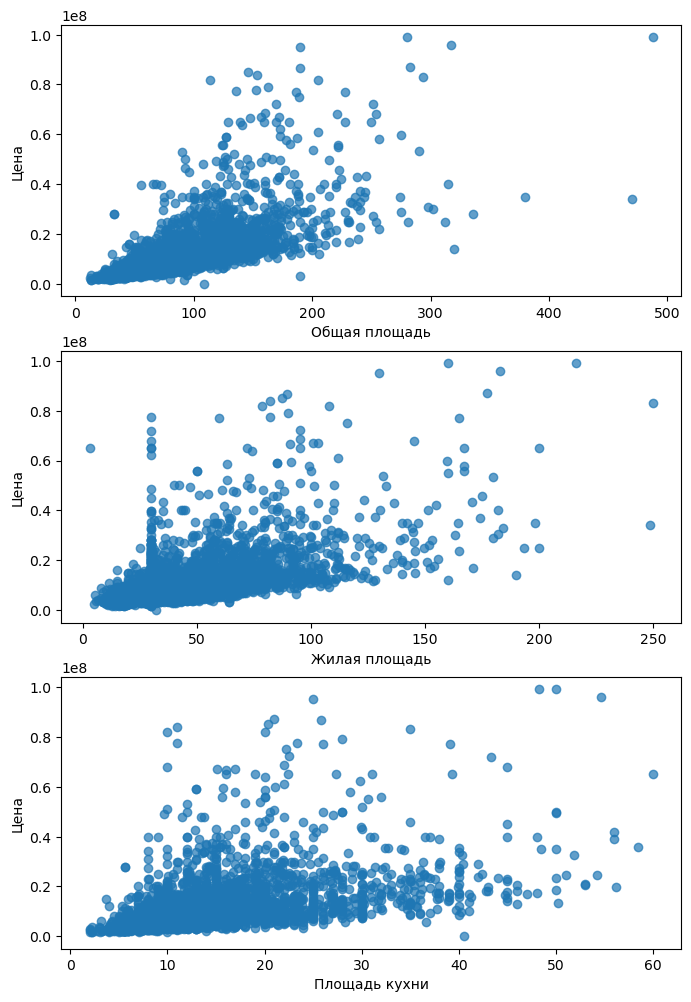

In [209]:
#d.plotting.scatter_matrix(df[['total_area', 'living_area', 'kitchen_area', 'rooms', 'last_price']]
fig, ax = plt.subplots(4, 1, figsize=(8, 12))
ax[0].scatter(x=df['total_area'], y=df['last_price'], alpha=0.7)
ax[0].set_xlabel('Общая площадь')
ax[0].set_ylabel('Цена')
ax[1].scatter(x=df['living_area'], y=df['last_price'], alpha=0.7)
ax[1].set_xlabel('Жилая площадь')
ax[1].set_ylabel('Цена')
ax[2].scatter(x=df['kitchen_area'], y=df['last_price'], alpha=0.7)
ax[2].set_xlabel('Площадь кухни')
ax[2].set_ylabel('Цена')
plt.show()

In [215]:
# найдем медианные значения цены для объектов с разным количеством комнат
rooms_prices = df.groupby('rooms')['last_price'].median()

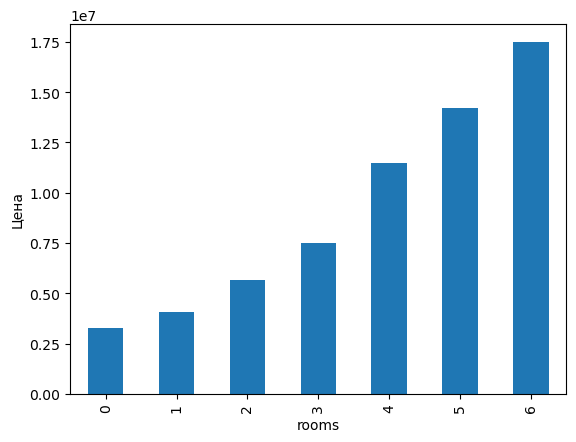

In [220]:
rooms_prices.plot(kind='bar', 
                  ylabel='Цена')
plt.show()

- Общая площадь имеет выраженную корреляцию с общей стоимостью и, вероятно, оказывает на нее значимое влияние.
- Жилая площадь имеет чуть менее выраженную, но все же значимую корреляцию и также оказывает влияние на цену.
- Влияние на стоимоть площади кухни ниже, однако положительная корреляция также прослеживается.
- Медианная стоимость квартиры значимо растет при увеличении числа комнат

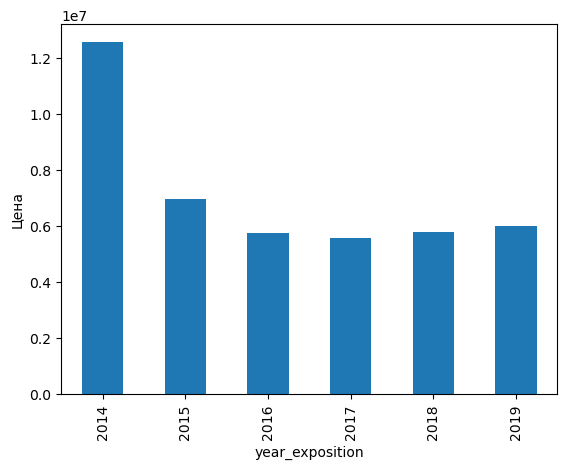

In [226]:
years_prices = df.groupby('year_exposition')['last_price'].median()
years_prices.plot(kind='bar', 
                  ylabel='Цена')
plt.show()

In [ ]:
price_1m2: цена 1 кв метра
weekday_exposition: день недели публикации объявления
month_exposition: месяц публикации объявления
year_exposition: год публикации объявления
floor_type: тип этажа квартиры (значения — «первый», «последний», «другой»)
city_centers_nearest_km: расстояние до центра города в километрах

### Напишите общий вывод

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [ ]  Найдены пропущенные значения.
- [ ]  Пропущенные значения заполнены там, где это возможно.
- [ ]  Объяснено, какие пропущенные значения обнаружены.
- [ ]  В каждом столбце установлен корректный тип данных.
- [ ]  Объяснено, в каких столбцах изменён тип данных и почему.
- [ ]  Устранены неявные дубликаты в названиях населённых пунктов.
- [ ]  Обработаны редкие и выбивающиеся значения (аномалии).
- [ ]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [ ]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [ ]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [ ]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [ ]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [ ]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [ ]  На каждом этапе сделаны промежуточные выводы.
- [ ]  В конце проекта сделан общий вывод.